In [2]:
import sys
if "../.." not in sys.path:
    sys.path.insert(0, "../..")

# EDA to establish method for time rescaling in cleaning CUE data 

Will be obsolete after incorporating into regular .py script

In [3]:
# Temp file for testing time correction

import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils.colors import *

DATA_FILE = "../clean/CUE2/dFBA.pkl"

# Load condition data
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)

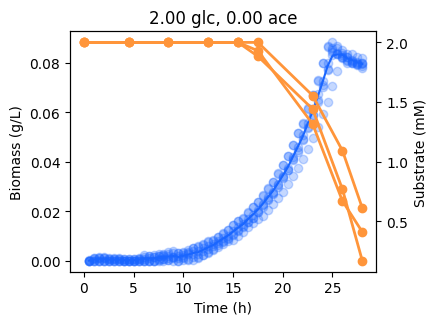

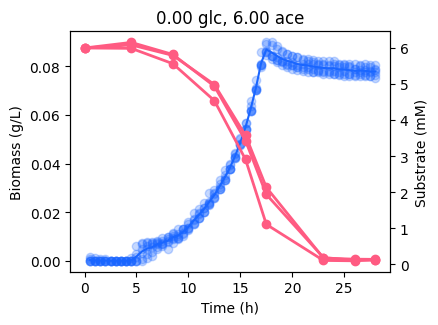

In [4]:
# To fit the uptake parameters, the plan is to:
# 1. Extract the region of data where the uptake rate is likely saturated (i.e. dN/dt ~= constant * X).
#    I assume this is true for the exponential phase of growth, so I extract that portion of the growth curve below.
# 2. Next, I fit the V_maxes by fitting the nutrient data over the exponential period. To do so, I used WolframAlpha to
#    solve dN/dt = -V_max * X(t), with X(t) = X_0 * exp(mu * t). The solution is listed below.
#    Note that using the closed-form solution does not take into account all the X(t) datapoints, so it may be slightly better
#    to use numerical integration to fit the V_maxes.
# 3. Finally, I fit the K_m's by fitting the nutrient data over the whole growth curve, fixing the V_maxes from above.

# Plot data function for use later
def plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs, N_obs_replicates, lw=2, N_color = C_GLUCOSE):
    ax.plot(t_X_obs, X_obs_replicates.T, marker="o", lw=0, color=C_BIOMASS, alpha=0.25)
    ax.plot(t_X_obs, X_obs_replicates.mean(axis=0), color=C_BIOMASS)
    ax2 = ax.twinx()
    ax2.plot(t_N_obs, N_obs_replicates.T, marker="o", lw=lw, color=N_color)

    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Biomass (g/L)")
    ax2.set_ylabel("Substrate (mM)")

    return ax, ax2

# Plot data
for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue
    
    # Get raw data
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = dat["raw"]["raw_b"]
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"]
    N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"] 

    # Plot raw data
    fig, ax = plt.subplots()
    plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs, N_obs_replicates, N_color = C_GLUCOSE if g > 0 else C_ACETATE)
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")
    fig.tight_layout()
    fig.set_size_inches(4, 3)


Growth terminates before substrates are exhausted - need to implement a time shift correction.

Let's use a dead-simple model of the growth curve up until stationary, where we assume $K_M \approx 0$:

https://www.desmos.com/calculator/ajlshnmow7


/tmp/ipykernel_10486/3913222121.py:38: RuntimeWarning: invalid value encountered in divide
  dX_dt_CV = dX_dt_std / np.abs(mean_dX_dt)
/tmp/ipykernel_10486/3913222121.py:38: RuntimeWarning: divide by zero encountered in divide
  dX_dt_CV = dX_dt_std / np.abs(mean_dX_dt)


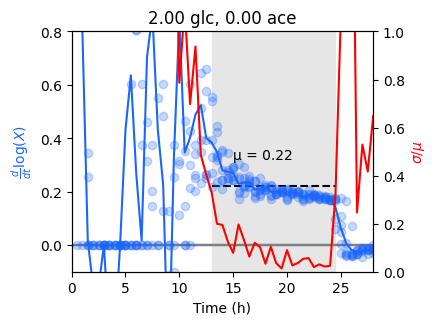

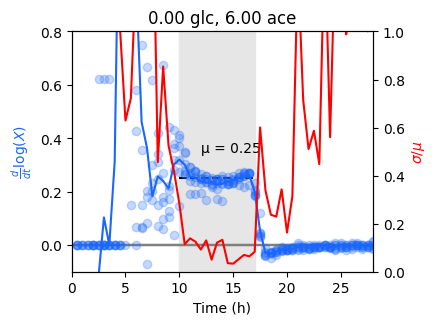

In [5]:
# To fit the uptake parameters, we first need to extract the exponential phase of growth,
# where the uptake rate is likely saturated. 
# Below, I use a method where I look for regions where the mean instantaneous growth rate is greater than a threshold,
# and the coefficient of variation (CV) of instantaneous growth rates across replicates is less than a threshold.

NO_GROWTH_THRESHOLD = 0.01
CV_THRESHOLD = 0.35

DETECTION_LIMIT = 1e-4  # Constant to add to prevent log of zero

exponential_regions = {}
growth_rates = {}
for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue

    # Get raw data, putting biomass on log-scale
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = np.log(dat["raw"]["raw_b"] + DETECTION_LIMIT)

    # Plot dlog(X)/dt
    fig, ax = plt.subplots()
    mean_dX_dt = np.mean([np.gradient(X_obs, t_X_obs) for X_obs in X_obs_replicates], axis=0)
    for X_obs in X_obs_replicates:
        dX_dt = np.gradient(X_obs, t_X_obs)
        ax.hlines(0, 0, t_X_obs[-1], color="0.5", linestyle="-", zorder=-1)
        ax.plot(t_X_obs, dX_dt, marker="o", lw=0, color=C_BIOMASS, alpha=0.25)
    ax.plot(t_X_obs, mean_dX_dt, color=C_BIOMASS)
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")
    ax.set_xlim(0, t_X_obs[-1])
    ax.set_ylim(-0.1, 0.8)
    ax.set_ylabel(r"$\frac{{d}}{{dt}}\log (X)$", color=C_BIOMASS)
    ax.set_xlabel("Time (h)")

    # Get the standard deviation of the gradient
    ax2 = ax.twinx()
    dX_dt_std = np.std([np.gradient(X_obs, t_X_obs) for X_obs in X_obs_replicates], axis=0)
    dX_dt_CV = dX_dt_std / np.abs(mean_dX_dt)
    ax2.plot(t_X_obs, dX_dt_CV, color="r")
    ax2.set_ylim(0, 1)
    ax2.set_ylabel(r"$\sigma/\mu$", color="r")

    # Okay, let's say that the exponential region is where the standard deviation
    # is less than 0.05, and the gradient is greater than 0.1
    # exponential_region = (dX_dt_std < STD_THRESHOLD) & (mean_dX_dt > NO_GROWTH_THRESHOLD)
    exponential_region = (dX_dt_CV < CV_THRESHOLD) & (mean_dX_dt > NO_GROWTH_THRESHOLD)
    t_exponential = t_X_obs[exponential_region]

    # Store the exponential region
    exponential_regions[(g, a)] = exponential_region

    # Calculate the growth rate
    growth_rate = np.mean(mean_dX_dt[exponential_region])
    growth_rates[(g, a)] = growth_rate

    # Plot the exponential region
    ax.fill_between(t_X_obs, -1, 1, where=exponential_region, color="0.9", zorder=-2)
    ax.hlines(growth_rate, t_exponential[0], t_exponential[-1], color="k", linestyle="--", zorder=-1)
    ax.text(t_exponential[0] + 2, growth_rate + 0.1, f"μ = {growth_rate:.2f}", horizontalalignment="left")

    fig.tight_layout()
    fig.set_size_inches(4, 3)
        

In [6]:
# Extract lag and stationary phase times
# for each condition, using the exponential region

t_l = {}
t_s = {}
for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue

    # Get raw data, putting biomass on log-scale
    t_X_obs = dat["raw"]["raw_b_t"]

    t_l[(g, a)] = t_X_obs[exponential_regions[(g, a)]].min()
    t_s[(g, a)] = t_X_obs[exponential_regions[(g, a)]].max()

Condition: 2.00 glc, 0.00 ace
  k: 5.04, alpha: 0.85
Condition: 0.00 glc, 6.00 ace
  k: 19.05, alpha: 0.94


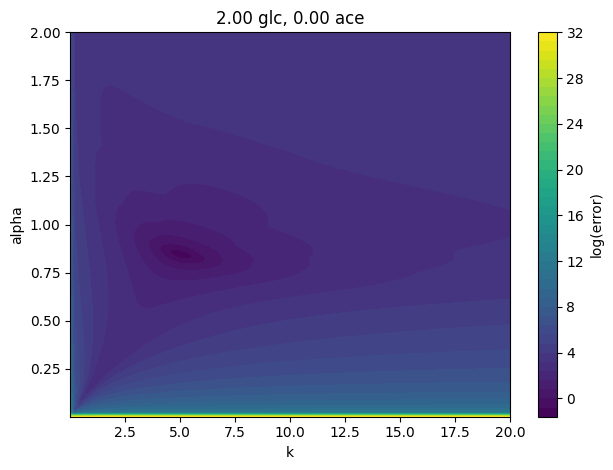

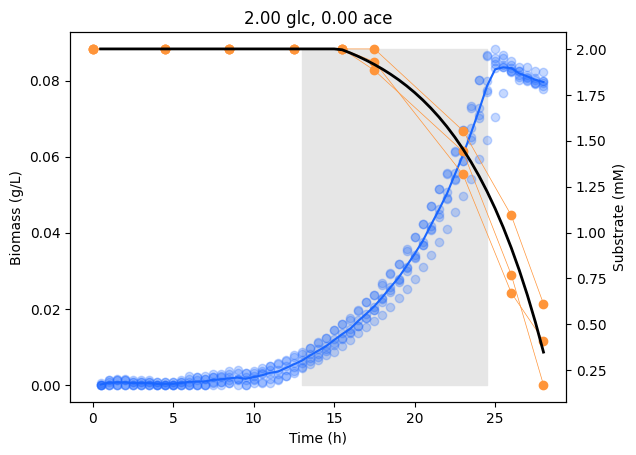

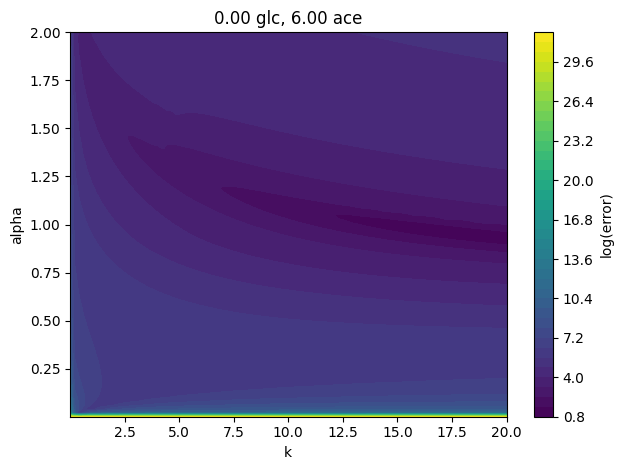

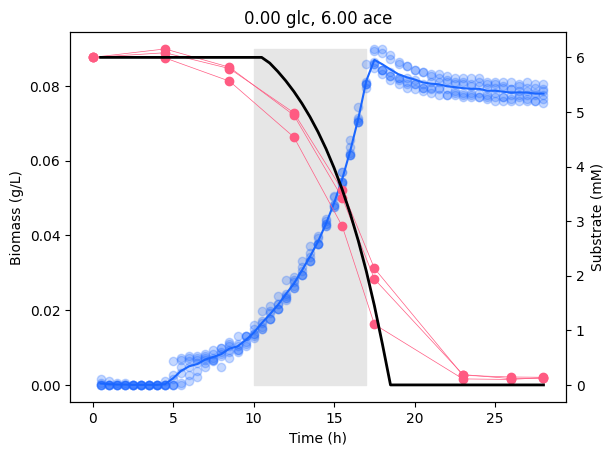

In [7]:
from scipy.optimize import minimize

alphas = {}

for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue

    # Get known variables
    N0 = max(g, a).magnitude
    t_lag = t_l[(g, a)]
    X0 = dat["mean"]["b_s"][dat["mean"]["b_t"] == t_lag][0]
    t_stationary = t_s[(g, a)]
    mu = growth_rates[(g, a)]


    # Get timepoints of N observations
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"].values

    # Define function to get N(t) values at observation times
    # for a given k, alpha
    def N_t(k, alpha, t=t_N_obs):
        after_t_l =  N0 + ((k * X0) / (mu * alpha)) * (1 - np.exp(mu * (alpha * t - t_lag)))
        result = np.array([N0] * len(t))
        result[t > t_lag / alpha] = after_t_l[t > t_lag / alpha]
        return result
    
    # Optimize k and alpha
    def error(params, lamb=0.5):
        # Term 1: SSE of N(t) vs. N_obs UP UNTIL STATIONARY
        k, alpha = params
        N_t_pred = N_t(k, alpha)
        N_t_pred[N_t_pred < 0] = 0

        N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"]

        term1 = np.sum((N_obs_replicates - N_t_pred) ** 2)

        # Term 2: penalty for zero point != t_stationary / alpha
        t_zero = t_lag / alpha + (1 / (alpha * mu)) * np.log(1 + N0 * mu * alpha / (k * X0))
        term2 = (t_zero - t_stationary / alpha) ** 2
        return term1 + lamb * term2

    # Plot error surface
    k_vals = np.linspace(1e-6, 20, 100)
    alpha_vals = np.linspace(1e-6, 2, 100)
    K, A = np.meshgrid(k_vals, alpha_vals)
    error_surface = np.zeros(K.shape)
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):
            k = K[i, j]
            alpha = A[i, j]
            error_surface[i, j] = error([k, alpha])
    error_surface = np.log(error_surface)
    fig, ax = plt.subplots()
    ax.contourf(K, A, error_surface, levels=50, cmap="viridis")
    ax.set_xlabel("k")
    ax.set_ylabel("alpha")
    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")
    fig.colorbar(ax.contourf(K, A, error_surface, levels=50, cmap="viridis"), label="log(error)")
    fig.tight_layout()
    # fig.set_size_inches(4, 3)

    minimizer = minimize(error, [1, 1], bounds=[(0, None), (1e-6, None)])
    k, alpha = minimizer.x

    # Store the parameters
    alphas[(g, a)] = alpha

    print(f"Condition: {g.magnitude:.2f} glc, {a.magnitude:.2f} ace")
    print(f"  k: {k:.2f}, alpha: {alpha:.2f}")

    # Plot the data
    fig, ax = plt.subplots()
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = dat["raw"]["raw_b"]
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"]
    N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"]
    ax, ax2 = plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs, N_obs_replicates, lw=0.5, N_color = C_GLUCOSE if g > 0 else C_ACETATE)

    # Shade exponential region
    ax.fill_between(t_X_obs, 0, X_obs_replicates.max(), where=exponential_regions[(g, a)], color="0.9", zorder=-2)

    # Plot the fitted N(t)
    N_t_pred = N_t(k, alpha, t=t_X_obs)
    N_t_pred[N_t_pred < 0] = 0
    ax2.plot(t_X_obs, N_t_pred, color="k", lw=2)

    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")

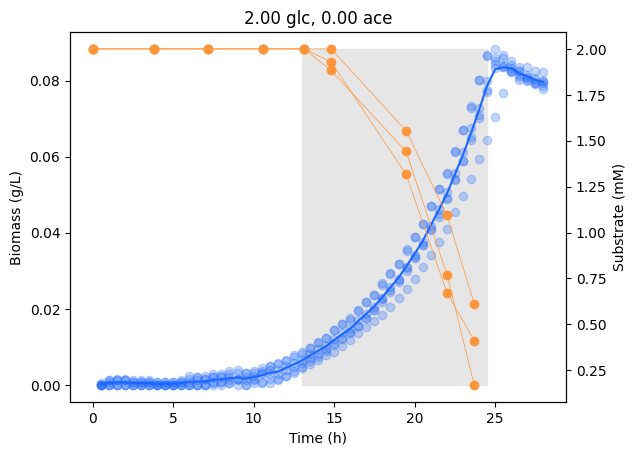

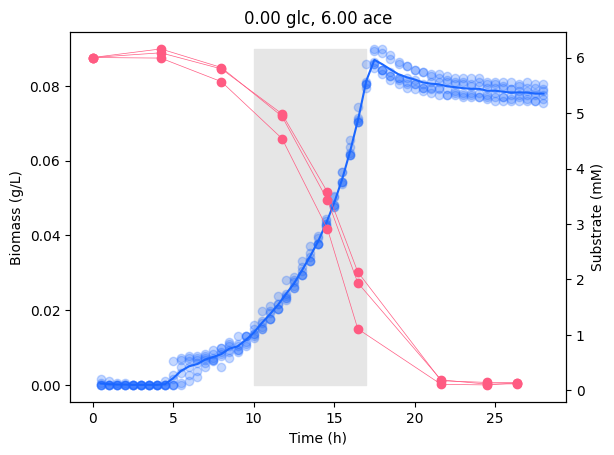

In [8]:
# Plot data with nutrients rescaled in time by alpha
for (g, a), dat in data.items():
    if g > 0 and a > 0:
        continue

    # Get raw data, putting biomass on log-scale
    t_X_obs = dat["raw"]["raw_b_t"]
    X_obs_replicates = dat["raw"]["raw_b"]

    # Get timepoints of N observations
    t_N_obs = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_t"].values
    N_obs_replicates = dat["raw"][f"raw_{'g' if g > 0 else 'a'}_s"]

    # Rescale time by alpha
    t_N_obs_rescaled = t_N_obs * alphas[(g, a)]

    # Plot the data
    fig, ax = plt.subplots()
    ax, ax2 = plot_data(ax, t_X_obs, X_obs_replicates, t_N_obs_rescaled, N_obs_replicates, lw=0.5, N_color = C_GLUCOSE if g > 0 else C_ACETATE)

    # Shade exponential region
    ax.fill_between(t_X_obs, 0, X_obs_replicates.max(), where=exponential_regions[(g, a)], color="0.9", zorder=-2)

    ax.set_title(f"{g.magnitude:.2f} glc, {a.magnitude:.2f} ace")